### Figure S7: Heat transport

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cf_xarray
import cartopy.crs as ccrs
import cmocean as cm
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
from dask.distributed import Client
import matplotlib.path as mpath
import scipy as sp
import scipy.interpolate
import scipy.ndimage
import scipy.io
import scipy.stats
import pandas as pd
from pandas import DataFrame
import cartopy.feature as cft
from metpy.interpolate import cross_section
from pathlib import Path
import xgcm
from pyproj import Proj, transform
import pyproj
from datetime import datetime, timedelta
from xhistogram.xarray import histogram
import matplotlib.ticker as mticker
import intake

In [2]:
from dask.distributed import Client

client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44215,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45307,Total threads: 1
Dashboard: /proxy/42717/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:41865,


In [3]:
cat = intake.cat.access_nri
experiment = '01deg_jra55v140_iaf_cycle4'
exp_extension = '01deg_jra55v140_iaf_cycle4_jra55v150_extension'

exp_ds = cat[experiment]
ext_ds = cat[exp_extension]

In [4]:
# Load model grid: 
walat = slice(-76,-63.99) # make sure t and u cells have same lengths
walon = slice(-140,-70)
aslat = slice(-75.5,-70)
aslon = slice(-120,-95)

grid_vars = ['xt_ocean','yt_ocean','st_edges_ocean','st_ocean']
coord_ds = exp_ds.search(
    variable=grid_vars, 
    file_id='ocean.1mon.nv:2.st_edges_ocean:76.st_ocean:75.xt_ocean:3600.yt_ocean:2700',
    frequency='1mon'
).to_dask(
    xarray_open_kwargs={
        'chunks' : "auto",
    }
)
xt_ocean = coord_ds['xt_ocean'].sel(xt_ocean=slice(-150,-50))
yt_ocean = coord_ds['yt_ocean'].sel(yt_ocean=slice(-80,-60))
st_ocean = coord_ds['st_ocean']

st_edges_ocean = coord_ds['st_edges_ocean']

hu = exp_ds.search(variable='hu').to_dask()['hu'].sel(yu_ocean=walat).sel(xu_ocean = walon).load()
ht = exp_ds.search(variable='ht').to_dask()['ht'].sel(yt_ocean=walat).sel(xt_ocean = walon).load()
area_t = exp_ds.search(variable='area_t').to_dask()['area_t'].sel(yt_ocean=walat).sel(xt_ocean = walon).fillna(0).load()
area_u = exp_ds.search(variable='area_u').to_dask()['area_u'].sel(yu_ocean=walat).sel(xu_ocean = walon).fillna(0).load()


In [5]:
# Load model output: 
start = '1984-01-01 00:00:00' # start date, 
end = '2019-01-01 00:00:00' # end date

# Load variables
t = exp_ds.search(variable=['temp'],frequency='1mon').to_dask()['temp'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start,end)) - 273.15
temp_xf = exp_ds.search(variable='temp_xflux_adv',frequency='1mon').to_dask()['temp_xflux_adv'].sel(yt_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start,end))
temp_yf = exp_ds.search(variable='temp_yflux_adv',frequency='1mon').to_dask()['temp_yflux_adv'].sel(yu_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start,end))
w = exp_ds.search(variable='wt',frequency='1mon').to_dask()['wt'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start,end))

# Load extension with intake:
start_ext = '2019-01-01 00:00:00' 
end_ext = '2024-01-01 00:00:00' # end date

# Load other 3D variables:
t_ext = ext_ds.search(variable=['temp'],frequency='1mon').to_dask()['temp'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start_ext,end_ext)) - 273.15
temp_xf_ext = ext_ds.search(variable='temp_xflux_adv',frequency='1mon').to_dask()['temp_xflux_adv'].sel(yt_ocean=walat).sel(xu_ocean = walon).sel(time = slice(start_ext,end_ext))
temp_yf_ext = ext_ds.search(variable='temp_yflux_adv',frequency='1mon').to_dask()['temp_yflux_adv'].sel(yu_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start_ext,end_ext))
w_ext = ext_ds.search(variable='wt',frequency='1mon').to_dask()['wt'].sel(yt_ocean=walat).sel(xt_ocean = walon).sel(time = slice(start_ext,end_ext))


In [6]:
# Concatenate and create annual
temp_full = xr.concat((t,t_ext),dim='time')
temp_xf_full = xr.concat((temp_xf,temp_xf_ext),dim='time')
temp_yf_full = xr.concat((temp_yf,temp_yf_ext),dim='time')
w_full = xr.concat((w,w_ext),dim='time')
# Calculate annual
t_an = temp_full.resample({'time':'Y'}).mean('time')
temp_xf_an = temp_xf_full.resample({'time':'Y'}).mean('time')
temp_yf_an = temp_yf_full.resample({'time':'Y'}).mean('time')
w_an = w_full.resample({'time':'Y'}).mean('time')


In [7]:
# Calculate heat flux amplitude:
txf_u = temp_xf_an.rename({'yt_ocean':'yu_ocean'}).assign_coords(yu_ocean = temp_yf_an.yu_ocean)
tyf_u = temp_yf_an.rename({'xt_ocean':'xu_ocean'}).assign_coords(xu_ocean = temp_xf_an.xu_ocean)
temp_flux = np.sqrt(txf_u**2+tyf_u**2)

In [8]:
# Calculate layer thickness
# Import edges of st_ocean and add lat/lon dimensions:
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean': ht.yt_ocean, 'xt_ocean': ht.xt_ocean}, axis=[1,2])

# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = t.st_ocean
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean': 'st_ocean'}))
thickness = thickness.fillna(0)

In [9]:
# Calculate temperature tendency 
cp = 4000
rho0 = 1025
temp_ten = (cp*rho0*thickness*area_t*temp_full.chunk(time=-1).differentiate('time',datetime_unit='s')) 


In [10]:
above1000 = ht.where(ht>=1000,1) # set all values smaller than 1000 to 1
above1000_tcells = above1000.where(above1000 < 1000) # remove all values bigger than 1000
above1000_tcells = xr.where(((above1000_tcells.xt_ocean<-111) & (above1000_tcells.yt_ocean<-72.6)),np.nan,above1000_tcells) # remove southwest corner that is dynamically part of the Dotson-Getz trough controlled area

In [11]:
# Compute horizontal convergence
zonal_adv = (((temp_xf_full.shift(xu_ocean=1).fillna(0)-temp_xf_full.fillna(0)))).rename({'xu_ocean':'xt_ocean'})
meridional_adv = (((temp_yf_full.shift(yu_ocean=1).fillna(0)-temp_yf_full.fillna(0)))).rename({'yu_ocean':'yt_ocean'})
zonal_adv.coords['xt_ocean'] = meridional_adv.coords['xt_ocean']
meridional_adv.coords['yt_ocean'] = zonal_adv.coords['yt_ocean']


In [12]:
print('Compute vertical convergence')
hflux_w = (temp_full.interp(st_ocean = w_full.sw_ocean.values).rename({'st_ocean': 'sw_ocean'})*w_full.fillna(0)*cp*rho0*area_t).fillna(0)
vert_adv = ((hflux_w-hflux_w.shift(sw_ocean = 1))).rename({'sw_ocean':'st_ocean'})
vert_adv.coords['st_ocean'] = temp_xf_full.coords['st_ocean']

Compute vertical convergence


In [13]:
temp_adv = zonal_adv+meridional_adv+vert_adv
temp_mix = temp_ten - temp_adv

In [14]:
# Load the calculations for the AS region:
temp_ten_as = temp_ten.sel(st_ocean = slice(100,1000)).sel(xt_ocean = slice(-120,-95)).sel(yt_ocean = slice(-76,-70)).resample({'time':'Y'}).mean()#.load()
temp_adv_as = temp_adv.sel(st_ocean = slice(100,1000)).sel(xt_ocean = slice(-120,-95)).sel(yt_ocean = slice(-76,-70)).resample({'time':'Y'}).mean()#.load()
temp_mix_as = temp_mix.sel(st_ocean = slice(100,1000)).sel(xt_ocean = slice(-120,-95)).sel(yt_ocean = slice(-76,-70)).resample({'time':'Y'}).mean()#.load()

In [15]:
# Load HVE and WMP
# Load WMP on gamma:
wmp_gamma = xr.open_dataset('/g/data/jk72/or6852/ensoant/cycle4_wmp_gamma_on_stocean.nc')['WMP']
hve_gamma = temp_full-temp_full.mean('time')-wmp_gamma

wmp_gamma_an = wmp_gamma.resample({'time':'Y'}).mean()
hve_gamma_an = t_an-t_an.mean('time')-wmp_gamma_an

In [16]:
# Set mask for coastal box
pibs_mask = xr.where((ht.sel(xt_ocean = slice(-110,-101.5)).sel(yt_ocean = slice(-75.2,-73.2)).xt_ocean<-103.5) & (ht.sel(xt_ocean = slice(-110,-101.5)).sel(yt_ocean = slice(-75.2,-73.2)).yt_ocean>-74.5),np.nan,1)

hve_pibsa = (hve_gamma_an*pibs_mask).sel(st_ocean = slice(200,400)).weighted(thickness*area_t).mean({'st_ocean','yt_ocean','xt_ocean'}).load()
wmp_pibsa = (wmp_gamma_an*pibs_mask).sel(st_ocean = slice(200,400)).weighted(thickness*area_t).mean({'st_ocean','yt_ocean','xt_ocean'}).load()

In [17]:
# Load some time series that we will need in the next cell:
wmp_pib_ten = wmp_pibsa.differentiate('time',datetime_unit='s').load()

In [18]:
# Define for plotting
land_u = xr.where(np.isnan(hu.rename('land')), 1, np.nan)
land = xr.where(np.isnan(ht.rename('land')), 1, np.nan)
land100 = xr.where(np.isnan(ht.where(ht>100).rename('land')), 1, np.nan)

In [19]:
# Plot parametres: define projection and boundary path, landmask

xt2d = xt_ocean.expand_dims({'yt_ocean':yt_ocean})
yt2d = yt_ocean.expand_dims({'xt_ocean':xt_ocean})

def make_boundary_path(longitudes, latitudes):
    """
    Return a path around boundary to create a sector map, then cut it out given
    longitudes and latitudes.
    """
    boundary_path = np.array([longitudes[-1, :], latitudes[-1, :]])
    boundary_path = np.append(boundary_path, np.array([longitudes[::-1, -1], latitudes[::-1, -1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([longitudes[1, ::-1],  latitudes[1, ::-1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([longitudes[:, 1],     latitudes[:, 1]]), axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

# Eastern Amundsen for HVE-WMP
midlon = -107.5
maxlon = -95
minlon = -120
minlat = -75.609
maxlat = -70.509
midlat = (minlat + maxlat)/2
lons = xt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = yt2d.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)}).T
boundary_path_pibm = make_boundary_path(lons, lats)
extent_pibm = [minlon,maxlon,minlat,maxlat]
projection_pibm = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)


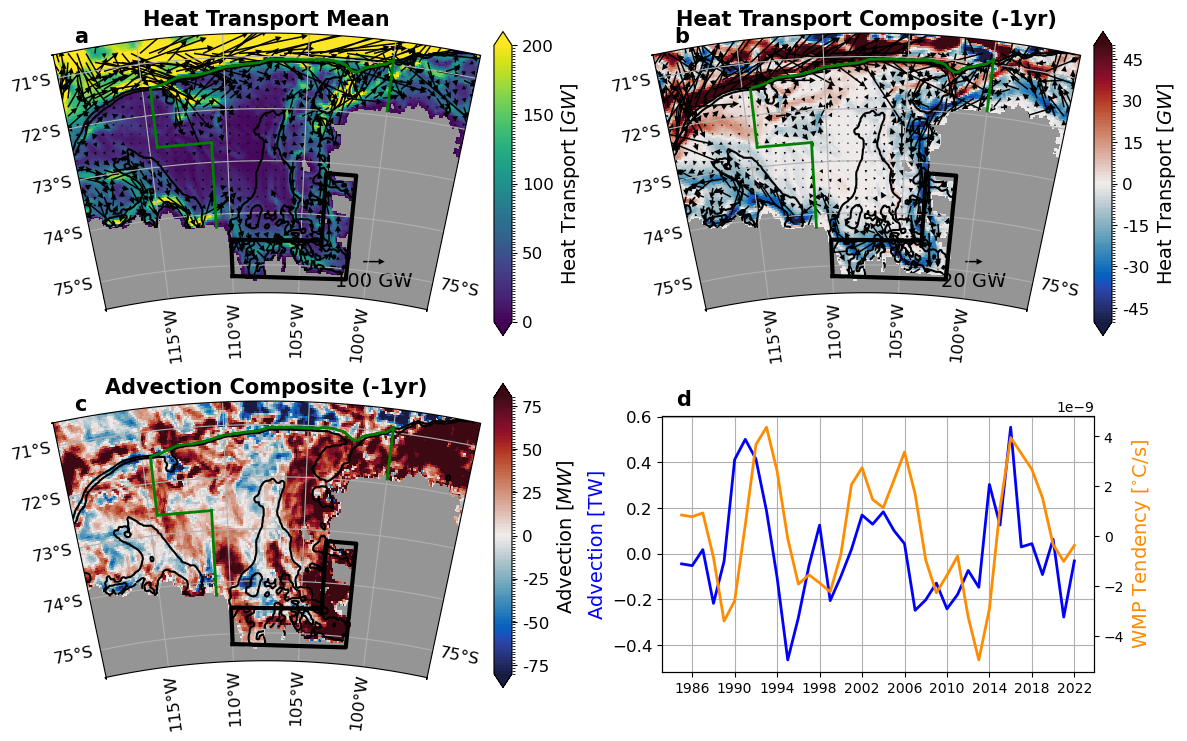

In [21]:
let = ['a','b','c','d','e']
tit = ['Heat Transport Mean', 'Heat Transport Composite (-1yr)', 'Advection Composite (-1yr)']
fig = plt.figure(figsize=(12,8))
for i in range(3):
    if i==0:
        ax1 = plt.axes([0.06,0.52,0.36,0.38],projection = projection_pibm)
    elif i==1:
        ax1 = plt.axes([0.56,0.52,0.36,0.38],projection = projection_pibm)
    elif i==2:
        ax1 = plt.axes([0.06,0.06,0.36,0.38],projection = projection_pibm)
    ax1.set_extent(extent_pibm, crs=ccrs.PlateCarree())
    gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.right_labels = False
    gl.top_labels = False
    gl.xlocator = mticker.FixedLocator([-115, -110, -105, -100,-95])
    gl.ylocator = mticker.FixedLocator([-75, -74, -73, -72,-71])
    gl.xlabel_style = {'size': 12, 'color': 'k'}
    gl.ylabel_style = {'size': 12, 'color': 'k'}
    ax1.set_boundary(boundary_path_pibm, transform=ccrs.PlateCarree())   
    if i==0:
        p1 = (1e-9*temp_flux).sel(st_ocean = slice(100,1000)).sum('st_ocean').mean('time').plot(ax=ax1,
                x='xu_ocean', y='yu_ocean', levels = np.linspace(0,200,101), add_colorbar = False, extend='both',
                transform=ccrs.PlateCarree())
        p2 = ax1.quiver(txf_u.xu_ocean,txf_u.yu_ocean,txf_u.sel(st_ocean = slice(100,1000)).sum('st_ocean').mean('time').values,tyf_u.sel(st_ocean = slice(100,1000)).sum('st_ocean').mean('time').values, color = 'k',regrid_shape=30, scale=2e12, width=0.0035, headwidth=4, headlength=4, headaxislength=4,transform = ccrs.PlateCarree())
        ax1.quiverkey(p2, X=.75, Y =0.2, U=1e11,
             label='100 GW', labelpos='S', fontproperties=({'size':14}))
        
    elif i==1:
        p3 = (1e-9*(temp_flux-temp_flux.mean('time'))).sel(st_ocean = slice(100,1000)).sum('st_ocean').where(wmp_pib_ten.rolling(time=3,center=True).mean().roll(time=-1)>2e-9).mean('time').plot(ax=ax1,
                x='xu_ocean', y='yu_ocean', levels = np.linspace(-50,50,101), add_colorbar = False, cmap=cm.cm.balance, extend='both',
                transform=ccrs.PlateCarree())
        p4 = ax1.quiver(txf_u.xu_ocean,txf_u.yu_ocean,(txf_u-txf_u.mean('time')).sel(st_ocean = slice(100,1000)).sum('st_ocean').where(wmp_pib_ten.rolling(time=3,center=True).mean().roll(time=-1)>2e-9).mean('time').values,(tyf_u-tyf_u.mean('time')).sel(st_ocean = slice(100,1000)).sum('st_ocean').where(wmp_pib_ten.rolling(time=3,center=True).mean().roll(time=-1)>2e-9).mean('time').values, color = 'k',regrid_shape=30, scale=5e11, width=0.0035, headwidth=4, headlength=4, headaxislength=4,transform = ccrs.PlateCarree())
        ax1.quiverkey(p4, X=.75, Y =0.2, U=2e10,
             label='20 GW', labelpos='S', fontproperties=({'size':14}))
    elif i==2:
        p5 = (1e-6*(temp_adv_as-temp_adv_as.mean('time'))).sel(st_ocean = slice(100,1000)).sum('st_ocean').where(wmp_pib_ten.rolling(time=3,center=True).mean().roll(time=-1)>2e-9).mean('time').plot(ax=ax1, # shifted by one year
                x='xt_ocean', y='yt_ocean', levels = np.linspace(-80,80,101), add_colorbar = False, cmap=cm.cm.balance, extend='both',
                transform=ccrs.PlateCarree())
    land100.plot(ax=ax1,cmap='Greys',add_colorbar=False, transform=ccrs.PlateCarree())       
    p7 = ht.plot.contour(ax=ax1,
                   x='xt_ocean', y='yt_ocean', levels=[600,1000], colors='k',linewidths=1.5, alphas=0.6,
                   transform=ccrs.PlateCarree())
    ax1.plot([-110,-101.5,-101.5,-103.5,-103.5,-110,-110],[-75.2,-75.2,-73.2,-73.2,-74.5,-74.5,-75.2],color='k', lw=3, transform=ccrs.PlateCarree())
    # green box around the AS area
    ax1.plot([-114.5,-114.5],[-71.5,-72.62],color='g',lw=2,transform=ccrs.PlateCarree())
    ax1.plot([-114.5,-111],[-72.62,-72.62],color='g',lw=2,transform=ccrs.PlateCarree())
    ax1.plot([-111,-111],[-72.62,-74.25],color='g',lw=2,transform=ccrs.PlateCarree())
    ax1.plot([-100,-100],[-71.9,-70.9],color='g',lw=2,transform=ccrs.PlateCarree())
    ht.sel(xt_ocean = slice(-114.5,-100)).sel(yt_ocean = slice(-71.5,-70.8)).plot.contour(ax=ax1,
                   x='xt_ocean', y='yt_ocean', levels=[1000], colors='g',linewidths=2,
                   transform=ccrs.PlateCarree())
    ax1.text(-118.5,-70.4,let[i],color='k',fontsize=15,fontweight='bold',transform=ccrs.PlateCarree())
    ax1.text(-107.5,-70.4,tit[i],horizontalalignment='center', fontsize = 15, fontweight = 'bold',transform=ccrs.PlateCarree())

axin1 = plt.axes([0.43,0.52,0.015,0.38])
cb=plt.colorbar(p1,cax=axin1, ticks = np.arange(0,250,50),orientation='vertical',aspect = 50)
cb.set_label('Heat Transport [$GW$]',fontsize=14)
cb.set_ticks(np.arange(0,250,50), labels=np.round(np.arange(0,250,50),0),fontsize=12)

axin2 = plt.axes([0.93,0.52,0.015,0.38])
cb=plt.colorbar(p3,cax=axin2, ticks = np.arange(-45,60,15),orientation='vertical',aspect = 50)
cb.set_label('Heat Transport [$GW$]',fontsize=14)
cb.set_ticks(np.arange(-45,60,15), labels=np.round(np.arange(-45,60,15),0),fontsize=12)

axin3 = plt.axes([0.43,0.08,0.015,0.38])
cb=plt.colorbar(p5,cax=axin3, ticks=np.arange(-75,100,25),orientation='vertical',aspect = 50)
cb.set_label('Advection [$MW$]',fontsize=14)
cb.set_ticks(np.arange(-75,100,25), labels=np.round(np.arange(-75,100,25),0),fontsize=12)


ax4 = plt.axes([0.57,0.1,0.36,0.32])
axb = ax4.twinx()
# Anomalies:
((temp_adv_as-temp_adv_as.mean('time'))*above1000_tcells*1e-12).sel(xt_ocean = slice(-114.5,-100)).sum({'st_ocean','xt_ocean','yt_ocean'}).assign_coords(time = temp_full.time[6::12]).chunk(time=-1).rolling(time=3,center=True).mean().plot(ax=ax4,color='b', lw=2,label='Advection')
wmp_pib_ten.assign_coords(time = temp_full.time[6::12]).chunk(time=-1).rolling(time=3,center=True).mean().plot(ax=axb,color='darkorange',lw=2)


ax4.grid()
#ax4.legend()
ax4.text(wmp_pibsa.time[0],.65,'d',fontsize=15,fontweight='bold')
ax4.set_title('')
ax4.set_ylabel('Advection [TW]', color='b', fontsize=14)
axb.set_ylabel('WMP Tendency [$^{\circ}$C/s]', color='darkorange', fontsize=14)
ax4.set_xlabel('', color='k',fontsize=14)
ax4.tick_params('y', colors='k', labelsize=12)
ax4.set_xticks(ticks=temp_full.time[30::48])

#plt.savefig('/home/581/or6852/plots/figures/supplement_heat_transport_v2.png')